In [1]:
from tomoSegmentPipeline.utils.common import read_array, write_array
from tomoSegmentPipeline.utils import setup
from cryoS2Sdrop.dataloader import singleCET_dataset, singleCET_FourierDataset
from cryoS2Sdrop.model import Denoising_3DUNet, Denoising_3DUNet_v2

import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchinfo import summary

import os
from torch.utils.data import Dataset, DataLoader

PARENT_PATH = setup.PARENT_PATH

%matplotlib inline
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [3]:
# cet_path = os.path.join(PARENT_PATH, 'data/raw_cryo-ET/tomo02.mrc') 
# cet_path = os.path.join(PARENT_PATH, 'data/S2SDenoising/dummy_tomograms/tomo02_dummy.mrc')
# gt_cet_path = None

cet_path = os.path.join(PARENT_PATH,
                        '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model14_noisyGaussPoiss.mrc')
gt_tomo_path = os.path.join(PARENT_PATH,
                        '/home/ubuntu/Thesis/data/S2SDenoising/dummy_tomograms/tomoPhantom_model14.mrc')

p = 0.3
vol_scale_factor = 4
subtomo_length = 96

my_dataset = singleCET_FourierDataset(cet_path, subtomo_length=subtomo_length, p=p, volumetric_scale_factor=vol_scale_factor,
                               gt_tomo_path=gt_cet_path)

Creating Fourier samples...
Done!


In [4]:
def collate_fn(batch):
    bernoulli_subtomo = torch.cat([b[0] for b in batch], axis=0)
    target = torch.cat([b[1] for b in batch], axis=0)
    
    try:
        gt_subtomo = torch.cat([b[2] for b in batch], axis=0)
    except TypeError:
        gt_subtomo = None
    
    return bernoulli_subtomo, target, gt_subtomo

# def collate_fn(batch):
#     "Default pytorch collate_fn does not handle None"
#     subtomo, target, mask, gt_subtomo = batch
#     return subtomo, target, mask, gt_subtomo

# def collate_fn(batch):
#     batch = [list(filter(lambda x: x is not None, b)) for b in batch]
#     return torch.utils.data.dataloader.default_collate(batch)

In [5]:
batch_size = 2
dloader = DataLoader(my_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, collate_fn=collate_fn)

# Model

In [6]:
for batch in dloader:
    subtomo, target, gt_subtomo = batch
    print(subtomo.shape, target.shape)
    break

torch.Size([12, 1, 96, 96, 96]) torch.Size([12, 1, 96, 96, 96])


In [18]:
gt_subtomo.dtype

torch.float32

In [7]:
gt_subtomo is None

False

In [8]:
n_features = 48
model = Denoising_3DUNet_v2(None, 0, n_features, p, n_bernoulli_samples=6)

In [9]:
model(subtomo).shape

torch.Size([12, 1, 96, 96, 96])

In [10]:
summary(model, (batch_size, 1, subtomo_length, subtomo_length, subtomo_length), device='cpu')

Layer (type:depth-idx)                   Output Shape              Param #
Denoising_3DUNet_v2                      [2, 1, 96, 96, 96]        --
├─PartialConv3d: 1-1                     [2, 48, 96, 96, 96]       1,344
├─Sequential: 1-2                        [2, 48, 48, 48, 48]       --
│    └─PartialConv3d: 2-1                [2, 48, 96, 96, 96]       62,256
│    └─LeakyReLU: 2-2                    [2, 48, 96, 96, 96]       --
│    └─MaxPool3d: 2-3                    [2, 48, 48, 48, 48]       --
├─Sequential: 1-3                        [2, 48, 24, 24, 24]       --
│    └─PartialConv3d: 2-4                [2, 48, 48, 48, 48]       62,256
│    └─LeakyReLU: 2-5                    [2, 48, 48, 48, 48]       --
│    └─MaxPool3d: 2-6                    [2, 48, 24, 24, 24]       --
├─Sequential: 1-4                        [2, 48, 12, 12, 12]       --
│    └─PartialConv3d: 2-7                [2, 48, 24, 24, 24]       62,256
│    └─LeakyReLU: 2-8                    [2, 48, 24, 24, 24]       --


# Loss function

In [11]:
pred = (1-mask)*model(subtomo)
pred.shape

torch.Size([2, 1, 96, 96, 96])

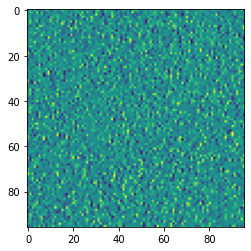

In [13]:
plt.imshow((subtomo+pred)[0][0][0].detach().numpy())

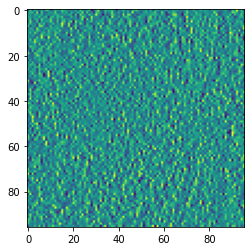

In [16]:
plt.imshow((subtomo+target)[0][0][0].detach().numpy())

In [14]:
from cryoS2Sdrop.losses import self2self_L2Loss, TotalVariation
# loss = self2self_L2Loss()
loss = TotalVariation()

In [13]:
loss(pred, target)

tensor(504.5622, grad_fn=<MeanBackward1>)

In [17]:
loss(subtomo+pred)

tensor([2315959.0000, 2294000.2500], grad_fn=<AddBackward0>)

# Monitor function: SSIM and PSNR

In [32]:
from pytorch_msssim import ssim
from torchmetrics.functional import peak_signal_noise_ratio, mean_squared_error

In [33]:
for batch in dloader:
    subtomo, target, gt_subtomo = batch
    print(subtomo.shape, target.shape)
    break
    
for i,j in zip(torch.split(subtomo, my_dataset.n_bernoulli_samples), torch.split(gt_subtomo, my_dataset.n_bernoulli_samples)):
    i, j
    print(i.shape)

torch.Size([12, 1, 96, 96, 96]) torch.Size([12, 1, 96, 96, 96])
torch.Size([6, 1, 96, 96, 96])
torch.Size([6, 1, 96, 96, 96])


In [34]:
data_range = 10
data_range

10

In [35]:
j.abs().max()

tensor(0.3015)

In [36]:
float(ssim(i.mean((0)), j.mean((0)))), float(peak_signal_noise_ratio(i.mean((0)), j.mean((0)), data_range=data_range))

(0.9746626019477844, 23.291927337646484)

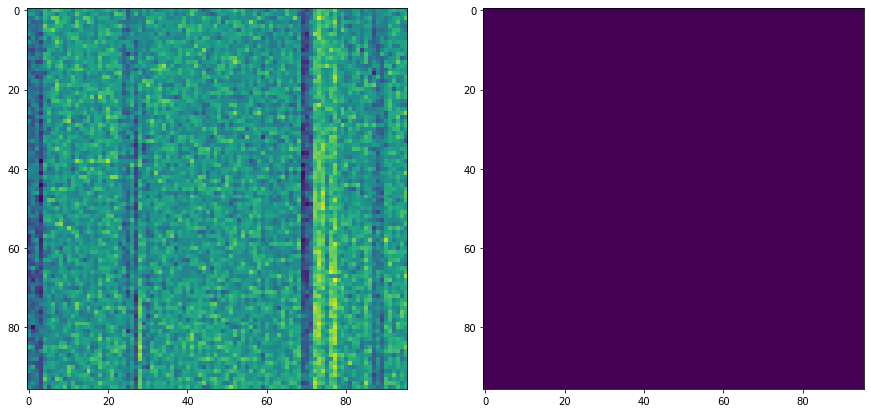

In [37]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(15, 8))
zidx = 46
ax0.imshow(i.mean((0, 1))[zidx])
ax1.imshow(j.mean((0, 1))[zidx])

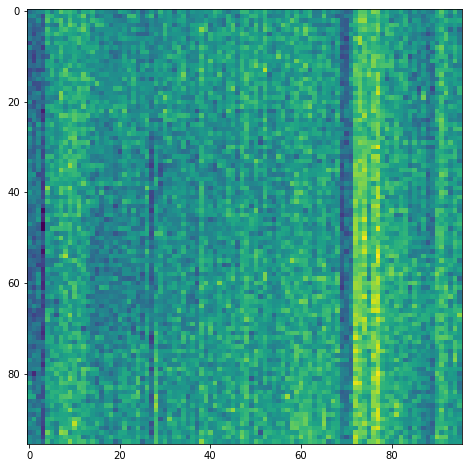

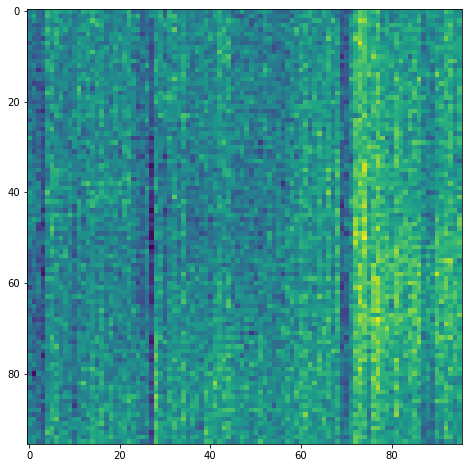

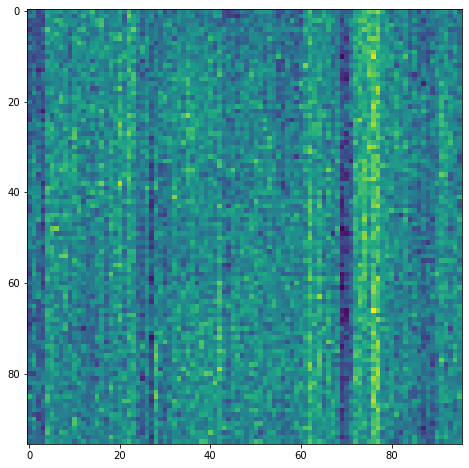

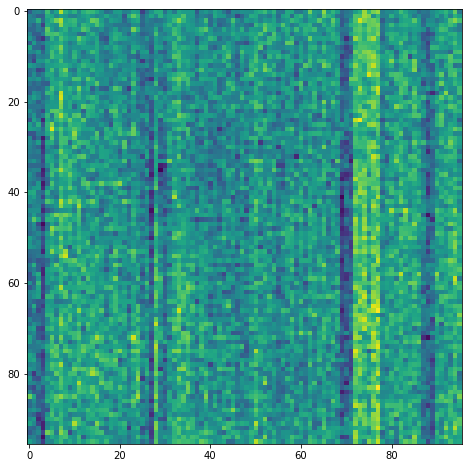

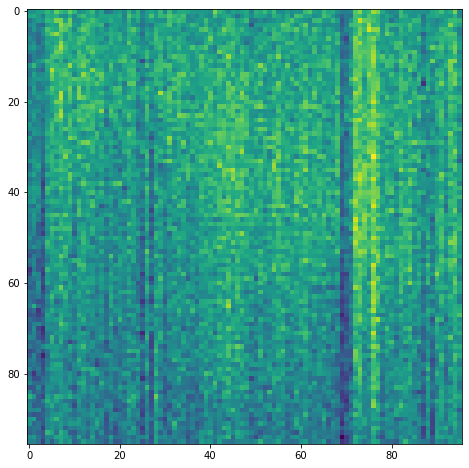

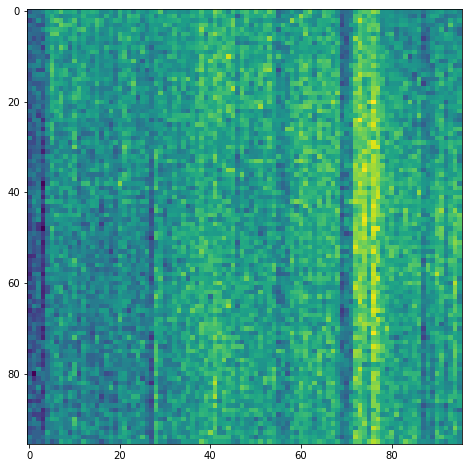

In [20]:
for v in i:
    plt.figure(figsize=(12, 8))
    plt.imshow(v[0][zidx])
    plt.show()